In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-twodim-diffadv)=
# Two-dimensional diffusion and advection

We next describe how to apply the method of lines to PDEs of the form

:::{math}
  :label: pde2d
  u_t = \phi(u,u_x,u_y,u_{xx},u_{xy},u_{yy}), \quad (x,y)\in [a,b]\times [c,d].
:::

The PDE may be of either parabolic or hyperbolic type, with the primary difference being potential restrictions on the time step size. To keep descriptions and implementations relatively simple, we will consider only periodic conditions, or Dirichlet boundary conditions imposed on all the edges of the rectangular domain.

As described in {numref}`section-twodim-tensorprod`, the rectangular domain is discretized by a grid $(x_i,y_j)$ for $i=0,\ldots,m$ and $j=0,\ldots,n$. The solution is semidiscretized as a matrix $\mathbf{U}(t)$ such that $U_{ij}\approx u(x_i,y_j,t)$. Terms involving the spatial derivatives of $u$ are readily replaced by discrete counterparts: $\mathbf{D}_x\mathbf{U}$ for $u_x$, $\mathbf{U}\mathbf{D}_{y}^T$ for $u_y$, and so on.

## Matrix and vector shapes

```{index} ! vec,! Julia; vec operation, ! unvec, Julia; reshape
```

Our destination is an IVP that can be solved by a Runge–Kutta or multistep solver. These solvers are intended for vector problems, but our unknowns naturally have a matrix shape, which is the most convenient for the differentiation formulas {eq}`partfpartx` and {eq}`partfparty`. Fortunately, it's easy to translate back and forth between a matrix and an equivalent vector. 

(definition-diffadv-vec)=
::::{proof:definition} vec and unvec operations
Let $\mathbf{A}$ be an $m\times n$ matrix. Define the **vec** function as stacking the columns of $\mathbf{A}$ into a vector, i.e.,

:::{math}
:label: vecdef
\operatorname{vec}(\mathbf{A}) =
\begin{bmatrix}
A_{11} \\ \vdots \\ A_{m1}  \\ \vdots  \\ A_{1n} \\ \vdots \\ A_{m n}
\end{bmatrix}.
:::

Let $\mathbf{z}$ be a vector of length $m n$. Define the **unvec** function as the inverse of vec:

:::{math}
:label: unvecdef
\operatorname{unvec}(\mathbf{z}) = \begin{bmatrix}
  z_1 & z_{m+1} & \cdots & z_{m(n-1)+1} \\ 
  z_2 & z_{m+2} & \cdots & z_{m(n-1)+2} \\ 
  \vdots & \vdots & & \vdots \\
  z_m & z_{2m} & \cdots & z_{m n} \\ 
\end{bmatrix}.
:::
::::

The function `vec` is built-in to Julia, whereas unvec is a particular use case of the `reshape` function. 

(demo-diffadv-vec)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

In [2]:
m = 2;  n = 3;
V = rand(1:9,m,n);

v = vec(V) 

6-element Vector{Int64}:
 9
 9
 2
 3
 9
 9

The `unvec` operation is the inverse of vec.

In [3]:
unvec = z -> reshape(z,m,n) 
unvec(v)

2×3 Matrix{Int64}:
 9  2  9
 9  3  9

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Periodic end conditions

If the boundary conditions are periodic, then the unknowns in the method of lines are the elements of the matrix $\mathbf{U}(t)$ representing grid values of the numerical solution. For the purposes of an IVP solution, this matrix is equivalent to the vector $\mathbf{u}(t)$ defined as $\mathbf{u}=\operatorname{vec}(\mathbf{U})$. 

```{index} heat equation
```
(demo-diffadv-heat)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We will solve a 2D heat equation, $u_t = 0.1(u_{xx} + u_{yy})$, on the square $[-1,1]\times[-1,1]$, with periodic behavior in both directions.

In [4]:
m = 60;  x,Dx,Dxx = FNC.diffper(m,[-1,1]);
n = 25;  y,Dy,Dyy = FNC.diffper(n,[-1,1]);
mtx = f -> [ f(x,y) for x in x, y in y ]
unvec = z -> reshape(z,m,n);

Note that the initial condition should also be periodic on the domain.

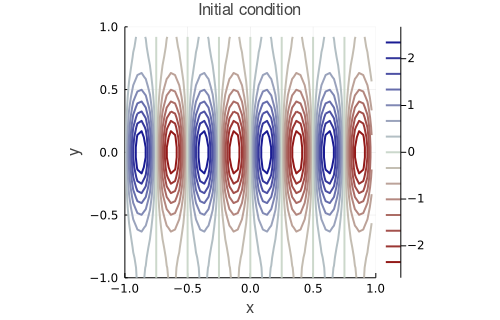

In [5]:
u_init = (x,y)->sin(4*π*x)*exp(cos(π*y))
U₀ = mtx(u_init)
M = maximum(abs,U₀)

contour(x,y,U₀',color=:redsblues,clims=(-M,M),aspect_ratio=1,
    xaxis=("x",(-1,1)),yaxis=("y",(-1,1)),title="Initial condition")    

This function computes the time derivative for the unknowns. The actual calculations take place using the matrix shape.

In [6]:
function dudt(u,α,t)
    U = unvec(u)
    Uxx = Dxx*U;  Uyy = U*Dyy'     # 2nd partials
    dUdt = α*(Uxx + Uyy);          # PDE
    return vec(dUdt)
end;

Since this problem is parabolic, a stiff integrator is appropriate.

In [7]:
IVP = ODEProblem(dudt,vec(U₀),(0,0.2),0.1)
sol = solve(IVP,Rodas4P());

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
Here is an animation of the solution. 

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```

Here `clims` are set so that colors remain at fixed values throughout the animation.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [8]:
anim = @animate for t in range(0,0.2,length=81)
    surface(x,y,unvec(sol(t))',color=:redsblues,clims=(-M,M),
        xaxis=(L"x",(-1,1)),yaxis=(L"y",(-1,1)),zlims=(-M,M),
        title=@sprintf("Heat equation, t=%.3f",t),
        dpi=100,colorbar=:none)
end 
closeall();  mp4(anim,"figures/diffadv-heat.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/repos/fnc-julia/twodim/figures/diffadv-heat.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/8K4be/src/animation.jl:114


Plots.AnimatedGif("/Users/driscoll/repos/fnc-julia/twodim/figures/diffadv-heat.mp4")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


## Dirichlet conditions

```{index} boundary conditions; numerical implementation of
```

In {numref}`section-diffusion-boundaries` we coped with boundary conditions by removing the boundary values from the vector of unknowns being solved in the semidiscretized ODE. Each evaluation of the time derivative required us to extend the values to include the boundaries before applying differentiation matrices in space. We proceed similarly here, except that we have changes in the shape as well as boundary conditions to consider. 

Suppose we are given a matrix $\mathbf{U}$ that represents the solution on an $(m+1)\times (n+1)$ grid, including boundary values. Then we define

:::{math}
:label: tpdeletion
\operatorname{pack}(\mathbf{U}) = \operatorname{vec}(\mathbf{E}_x \mathbf{U} \mathbf{E}_y^T),
:::

where 

$$
\mathbf{E}_x = \begin{bmatrix}
  0 & 1 & 0 & \cdots & 0 & 0 \\ 
  0 & 0 & 1 & \cdots & 0 & 0 \\ 
   &  &  & \ddots &  & \\
  0 & 0 & 0 & \cdots & 1 & 0 
\end{bmatrix}
$$

is $(m-1)\times (m+1)$, and $\mathbf{E}_y$ is analogous but of size $(n-1)\times (n+1)$. The left multiplication in {eq}`tpdeletion` deletes the first and last row of $\mathbf{U}$ and the right multiplication deletes its first and last column. All that remains, then, are the interior values, which are converted into a vector by the vec operator.

For the inverse transformation, let us be given a vector $\mathbf{w}$ of interior solution values. Then we define

$$
\operatorname{unpack}(\mathbf{w}) = \mathbf{E}_x^T \cdot \operatorname{unvec}(\mathbf{w}) \cdot \mathbf{E}_y.
$$

This operator reshapes the vector to a grid of interior values, then appends one extra zero row and column on each side of the grid.[^jacobian]

[^jacobian]: You might wonder why we use linear algebra to define the extension and deletion of boundary values rather than directly accessing row and column indices in the grid function. The linear algebra approach allows `DifferentialEquations` to compute the Jacobian matrix of the implicit IVP solver quickly using *automatic differentiation* tools, greatly speeding up the solution process. Since the matrices in our expressions are sparse, multiplications by them do not affect running time perceptibly.

Now suppose the ODE unknowns for the interior solution values are in the vector $\mathbf{w}(t)$. When we form $\operatorname{unpack}(\mathbf{w})$, we reinterpret the values on the tensor-product grid and then extend these values to zero around the boundary. If the boundary values are given as $g(x,y)$, then $g$ has to be evaluated at the boundary nodes of the grid and inserted into the grid function matrix. Then the grid values are used to compute partial derivatives in $x$ and $y$, the discrete form of the PDE is evaluated, and we pack the result as the computation of $\mathbf{w}'$. 

```{index} advection-diffusion equation
```

(demo-diffadv-advdiff)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We will solve an advection-diffusion problem, $u_t + u_x = 1 + \epsilon(u_{xx} + u_{yy})$, where $u=0$ on the boundary of the square $[-1,1]^2$. The outline of our approach is based on {numref}`Function {number} <function-parabolic>` for parabolic PDEs in one space dimension.

The first step is to define a discretization of the domain. We use the result to discretize an initial condition.

In [9]:
m = 50; n = 36;
x,Dx,Dxx = FNC.diffcheb(m,[-1,1])
y,Dy,Dyy = FNC.diffcheb(n,[-1,1])
U₀ = [ (1+y)*(1-x)^4*(1+x)^2*(1-y^4) for x in x, y in y ];

Next, we define the pack and unpack functions for the grid unknowns.

In [10]:
Ex = [zeros(m-1) I(m-1) zeros(m-1)]
Ey = [zeros(n-1) I(n-1) zeros(n-1)]
unvec = u -> reshape(u,m-1,n-1)

pack = U -> vec(Ex*U*Ey')
unpack = w -> Ex'*unvec(w)*Ey;

Now we can define and solve the IVP using a stiff solver.

In [11]:
function dwdt(w,ϵ,t)
    U = unpack(w)
    Ux,Uxx = Dx*U , Dxx*U
    Uyy = U*Dyy'
    dUdt = @. 1 - Ux + ϵ*(Uxx + Uyy)
    return pack(dUdt)
end

IVP = ODEProblem(dwdt,pack(U₀),(0.,2),0.05)
w = solve(IVP,Rodas4P());

When we evaluate `w` at a particular value of $t$, we get a vector of the interior grid values. The same `unpack` function above converts this to a complete matrix of grid values.

In [12]:
anim = @animate for t in 0:0.02:2
    U = unpack(w(t))
    surface(x,y,U',layout=(1,2),size=(640,320),
        xlabel=L"x",ylabel=L"y",zaxis=((0,2),L"u(x,y)"),
        color=:viridis,alpha=0.66,clims=(0,2),colorbar=:none,
        title="Advection-diffusion",dpi=100 )
    contour!(x,y,U',levels=24,aspect_ratio=1,
        subplot=2,xlabel=L"x",ylabel=L"y",
        color=:viridis,clims=(0,2),colorbar=:none,
        title=@sprintf("t = %.2f",t) )
end
closeall();  mp4(anim,"figures/diffadv-advdiff.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/repos/fnc-julia/twodim/figures/diffadv-advdiff.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/8K4be/src/animation.jl:114


Plots.AnimatedGif("/Users/driscoll/repos/fnc-julia/twodim/figures/diffadv-advdiff.mp4")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


```{index} wave equation
```

The wave equation introduces a little additional complexity. First, we write the 2D wave equation $u_{tt}=c^2(u_{xx}+u_{yy})$ in first-order form as

:::{math}
:label: wave2dfirst
    u_t &= v, \\
    v_t &= c^2(u_{xx}+u_{yy}).
:::

Now the grid unknowns are a pair of matrices $\mathbf{U}(t)$ and $\mathbf{V}(t)$. Typical boundary conditions would prescribe $u$ on all of the boundary and let $v$ be unspecified. Since the boundary values of $\mathbf{U}$ are prescribed, those values are omitted from the semidiscretization IVP, while all of $\mathbf{V}$ is included. All of these unknowns need to be packed into and unpacked from a single vector $\mathbf{w}(t)$ for the IVP solver. 

(demo-diffadv-wave)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We solve the wave equation with $c=1$ on the square $[-2,2]\times[-2,2]$, where $u=0$ on the boundary. We start with the discretization and initial condition.

In [13]:
m = 40;  n = 40;
x,Dx,Dxx = FNC.diffcheb(m,[-2,2])
y,Dy,Dyy = FNC.diffcheb(n,[-2,2])
U₀ = [ (x+0.2)*exp(-12*(x^2+y^2)) for x in x, y in y ]
V₀ = zeros(size(U₀));

We again define two functions for transforming between the matrix and vector representations. Unpacking extends the boundary values of $u$ by zeros, which would need to be modified if the PDE had a nonhomogeneous condition. Also note that there are two different sizes of unvec operations.

In [14]:
Ex = [zeros(m-1) I(m-1) zeros(m-1)]
Ey = [zeros(n-1) I(n-1) zeros(n-1)]
unvec_u = u -> reshape(u,m-1,n-1)
unvec_v = u -> reshape(u,m+1,n+1)
N = (m-1)*(n-1)

pack = (U,V) -> [ vec(Ex*U*Ey'); vec(V) ]
unpack = w -> ( Ex'*unvec_u(w[1:N])*Ey, unvec_v(w[N+1:end]) );

We can now define and solve the IVP. Since this problem is hyperbolic, not parabolic, a nonstiff integrator is faster than a stiff one.

In [15]:
function dwdt(w,c,t)
    U,V = unpack(w) 
    dUdt = V
    dVdt = c^2*(Dxx*U + U*Dyy')
    return pack(dUdt,dVdt)
end

IVP = ODEProblem(dwdt,pack(U₀,V₀),(0,4.0),1)
sol = solve(IVP,Tsit5());

In [16]:
anim = @animate for t in 0:4/100:4
    U,_ = unpack(sol(t))
    surface(x,y,U',layout=(1,2),size=(640,320),
        xlabel=L"x",ylabel=L"y",zaxis=((-0.1,0.1),L"u(x,y)"),
        color=:redsblues,alpha=0.66,clims=(-0.1,0.1),colorbar=:none,
        title="Wave equation",dpi=100 )
    contour!(x,y,U',levels=24,aspect_ratio=1,
        subplot=2,xlabel=L"x",ylabel=L"y",
        color=:redsblues,clims=(-0.1,0.1),colorbar=:none,
        title=@sprintf("t = %.2f",t) )
end
closeall();  mp4(anim,"figures/diffadv-wave.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/repos/fnc-julia/twodim/figures/diffadv-wave.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/8K4be/src/animation.jl:114


Plots.AnimatedGif("/Users/driscoll/repos/fnc-julia/twodim/figures/diffadv-wave.mp4")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Exercises

1. ⌨  For the given $u(x,y)$, make a plot of the given quantity on the square $[-2,2]^2$ using appropriate differentiation matrices.

    **(a)** $u(x,y) = \exp(x-y^2)$; plot $u_{xx}+u_{yy}$
    
    **(b)** $u(x,y) =\cos (\pi x)+\sin (\pi y)$; plot $u_x+u_y$
    
    **(c)** $u(x,y) =\exp(-x^2-4y^2)$; plot $x u_y$

2. ⌨ Following {numref}`Demo %s <demo-diffadv-heat>` as a model, solve the Allen–Cahn equation $u_t=u(1-u^2)+0.001(u_{xx}+u_{yy})$ on the square $[-1,1]^2$ with periodic conditions, taking $u(x,y,0)=\sin(\pi x)\cos(2\pi y)$. Use $m=n=60$ to solve up to $t=4$, and make an animation of the result. 
   

3. ⌨ Following {numref}`Demo %s <demo-diffadv-advdiff>` as a model, solve $u_t=y u_x-u_y+0.03(u_{xx}+u_{yy})$ on the square $[-1,1]^2$, with $u(x,y,0)=(1-x^2)(1-y^2)$ and homogeneous Dirichlet boundary conditions. Use $m=n=40$ to solve up to $t=2$, and make an animation of the result.

4. ⌨ Following {numref}`Demo %s <demo-diffadv-wave>` as a model, solve $u_{tt}=u_{xx}+u_{yy}+\cos(7t)$ on the square $[-1,1]^2$, with $u(x,y,0)=x(1-x^6)(1-y^2)$, $u_t(x,y,0)=0$, subject to homogeneous Dirichlet boundary conditions. Take $m=n=60$ to solve between $t=0$ and $t=12$, and make an animation of the result. 

5. From Maxwell's equations we can find a way to convert the wave equation to a first-order form that, unlike {eq}`wave2dfirst`, uses only first-order derivatives in space:

    :::{math}
    :label: wave2dTM
    u_t &= c^2(v_y - w_x),\\ 
    v_t &= u_y, \\ 
    w_t &= -u_x,
    :::

    subject to $u=0$ on the boundary.

    **(a)** ✍ Show that a solution of {eq}`wave2dTM` satisfies $u_t=c^2(u_{xx}+u_{yy})$.

    **(b)** ⌨ Solve {eq}`wave2dTM` with $c=2$ in the rectangle $x\in[-3,3]$, $y\in[-1,1]$, $u(x,y,0) = \exp(x-x^2)(9-x^2)(1-y^2)$, and $v=w=0$ at $t=0$. Use $m=50$ for $x$ and $n=25$ for $y$, solve for $0\le t \le 6$, and make an animation of the solution.